In [3]:
import os 
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.prompts import ChatPromptTemplate
from typing import Annotated, Sequence, Literal, List
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import Client
import langchainhub as hub
from langchain_core.documents import Document

load_dotenv()
os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_API_ENDPOINT = os.getenv('AZURE_API_ENDPOINT')
AZURE_DEPLOYMENT_NAME = os.getenv('AZURE_DEPLOYMENT_NAME')
AZURE_API_VERSION = os.getenv('AZURE_API_VERSION')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_PROJECT'] = 'Corrective-RAG'
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

client = Client(api_key=LANGCHAIN_API_KEY)

llm = AzureChatOpenAI(
    model='gpt-4.1-mini',
    azure_endpoint=AZURE_API_ENDPOINT,
    deployment_name=AZURE_DEPLOYMENT_NAME,
    api_version=AZURE_API_VERSION
)

### Vector DB Retriever

In [4]:
urls = [
    "https://docs.langchain.com/oss/python/langgraph/overview",
    "https://docs.langchain.com/oss/python/langgraph/workflows-agents",
    "https://docs.langchain.com/oss/python/langgraph/thinking-in-langgraph"
]

docs = [WebBaseLoader(url).load() for url in urls]

doc_list = [item for subtask in docs for item in subtask]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs_splitter = text_splitter.split_documents(doc_list)

embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-3-small",
    azure_endpoint=AZURE_API_ENDPOINT)

vector_store = Chroma.from_documents(docs_splitter, embeddings, collection_name='langgraph')

retriver = vector_store.as_retriever()

In [115]:
class AgentState(TypedDict):
    question: str 
    documents: List[str]
    generation: str 

In [132]:
def web_search(state:AgentState):
    """
    Web search based on the re-phrased question.
    
    Args:
        state(dict): The current graph state 
    
    Returns:
        state(dict): Updates documents key with appended web results    
    
    """
    print("--websearch---")
    websearch_tool = TavilySearchResults(k=3)
    question = state['question']
    web_results = websearch_tool.invoke(question)
    web_results_1 = '\n'.join(doc['content'] for doc in web_results)
    documents = []
    documents.append(web_results_1)
    
    return {'documents': documents, "question": question}

In [109]:
def router(state:AgentState):
    system = """You are an expert at routing a user question to a vectorstore or a websearch.
    The vectorstore contains documents related to Langgraph.
    Use the vectorstore for questions on these topics. Otherwise, use web search."""
    
    class RouteQuery(BaseModel):
        """Route a query to the most relevant datastore"""
        datasource: Literal['vectorstore', 'web_search'] = Field(...,description="Given a user question chosse to route it to web search or a vectorstore")
    
    route_prompt = ChatPromptTemplate.from_messages(
        [
         ('system', system),
         ('human', "{question}")   
        ]
    )
    llm_with_structured_output = llm.with_structured_output(RouteQuery)
    question_router = route_prompt | llm_with_structured_output
    
    question = state['question']
    
    response = question_router.invoke({'question': question})
    
    if response.datasource == 'vectorstore':
        print('---route question to vector store---')
        return 'vectorstore'
    elif response.datasource == 'web_search':
        print('---route question to web search---')
        return 'web_search'

In [42]:
def retrieve(state:AgentState):
    """
    Invokes the agent model to generate a response based on the current state. Given the question, it will decide to retrieve using the retriever tool, or simply end
    Args:
        state(messages): The current state 
    Returns:
        state(dict): New key added to the state, documents, that contains retrived_documents    
    """
    print('---retrieve---')
    question = state['question']
    docs = retriver.invoke(question)
    return {"documents": docs, "question": question}

In [73]:
def grade_documents(state:AgentState) -> Literal["generate", "transform_query"]:
    """Determines whether the retrieved documents are relevant to the question
    
    Args: 
        state (messages): the current state 
    Returns: 
        str: A decision for whether the documents are relevant ot not"""
    
    print("---Check Relevance---")
    
    class grade(BaseModel):
        """
        Binary score for relevance check
        """
        
        binary_score: str = Field(description="Documents are relavance to the question, score 'yes' or 'no'")
        
    llm_with_tool = llm.with_structured_output(grade)
    
    grade_prompt = PromptTemplate(
        template = """You are a grader assessing relevance of a retrieved document to a user question.\n
        Here is the retrived document: \n\n {document} \n\n
        Here is the user question: {question} \n 
        If the document contains keyword(s) or semantic meaing related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question""",
        input_variables = ["document", "question"],
    )
    
    chain = grade_prompt | llm_with_tool 
        
    question = state['question']
    
    doc_txt = ' '.join(doc.page_content for doc in state['documents'])
    
    scored_result = chain.invoke({"question": question, "document": doc_txt})

    score = scored_result.binary_score 
    
    if score == 'yes':
        print('---Decision: Docs Relevant---')
        return "generate"
    else:
        print("---Decision: Docs not relevant---")
        return "transform_query"

In [74]:
def generate(state:AgentState):
    """
    Generate answer
    
    Args:
        state(messages): the current state 
        
    Returns:
        dict: The updated message 
    """
    print("--Generate--")
    prompt = client.pull_prompt("rlm/rag-prompt")
    question = state['question']
    
    #docs = "\n\n".join(doc.page_content for doc in state['documents'])
    documents = state['documents']
    
    chain = prompt | llm | StrOutputParser()
    
    generation = chain.invoke({'context': documents, 'question': question})
    return {"generation": generation, "documents": documents, "question": question} 

In [90]:
def hallucination(state:AgentState):
    
    print('---Check Halucinations---')
    
    class GradeHallucination(BaseModel):
        """Binary score for hallucination present in generation answer"""
        
        binary_score: str = Field(description='Answer is grounded in the facts, "yes" or "no"')
        
    llm_with_structure = llm.with_structured_output(GradeHallucination)
    
    system = """You are a grader assessing whether an LLM generation is grounded in/supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in/supported by the set of facts
    """
    
    hallucination_prompt = ChatPromptTemplate(
        [
            ('system', system),
            ('human', "set of facts: \n\n {documents} \n\n LLM generation: {generation}")
        ]
    )
    
    hallucination_grader = hallucination_prompt | llm_with_structure
    response = hallucination_grader.invoke({'documents': state['documents'], 'generation': state['generation']})
    
    if response.binary_score == "yes":
        print("---Decision: Generation is grounded in documents")
        # check question-answering
        return "useful"
    else: 
        print("---Decision: Generation does not address question---")
        return "not useful"
    

In [88]:
def answer_grader(state:AgentState):
    
    class GradeAnswer(BaseModel):
        """Binary score for hallucination present in generation answer"""
        
        binary_score: str = Field(description='Answer address the question, "yes" or "no"')
        
    llm_with_structure = llm.with_structured_output(GradeAnswer)
    
    system = """You are a grader assessing whether an answer addresses / resolves a question. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question.
    """
    
    answer_grader_prompt = ChatPromptTemplate(
        [
            ('system', system),
            ('human', "user question: \n\n {question} \n\n LLM generation: {generation}")
        ]
    )
    
    answer_grade = answer_grader_prompt | llm_with_structure
    response = answer_grade.invoke({'question': state['question'], 'generation': state['generation']})
    
    return 
    

In [77]:
def transform_query(state:AgentState):
    print("--transform_query---")
    system = """You are a question re-writer that converts an input question to a better version that is optimized for web search
    Look at the input and try to reason about the underlying semnatic intent/meaning"""
    
    question = state["question"]
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', system),
            (
                'human', "Here is the question:\n\n {question} \n Formulate an improved question"
            ),
        ]
    ) 
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    question = question_rewriter.invoke({"question": question})
    return {"question": question}

In [134]:
workflow = StateGraph(AgentState)
workflow.add_node('web_search', web_search)
workflow.add_node('retrieve', retrieve)
workflow.add_node('generate', generate)
workflow.add_node('transform_query', transform_query)


workflow.add_conditional_edges(
    START, 
    router,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve"
    }
)

workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    'retrieve',
    grade_documents,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge('transform_query', 'retrieve')
workflow.add_conditional_edges(
    'generate',
    hallucination,
    {
        'useful': END,
        "not useful": "transform_query"
        
    }
)


In [135]:
graph = workflow.compile()

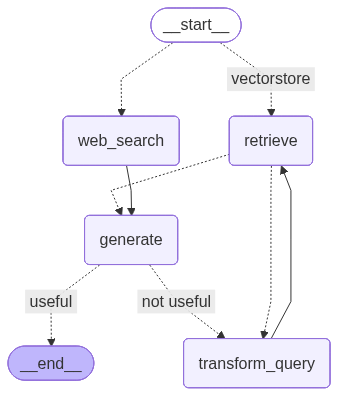

In [112]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [138]:
graph.invoke({'question': 'what is langraph?'})

---route question to vector store---
---retrieve---
---Check Relevance---
---Decision: Docs Relevant---
--Generate--
---Check Halucinations---
---Decision: Generation is grounded in documents


{'question': 'what is langraph?',
 'documents': [Document(metadata={'language': 'en', 'source': 'https://docs.langchain.com/oss/python/langgraph/overview', 'title': 'LangGraph overview - Docs by LangChain'}, page_content='Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.\nWe will commonly use LangChain components throughout the documentation to integrate models and tools, but you don’t need to use LangChain to use LangGraph. If you are just getting started with agents or want a higher-level abstraction, we recommend you use LangChain’s agents that provide pre-built architectures for common LLM and 